<a href="https://colab.research.google.com/github/hurshd0/DS-Unit-2-Regression-Classification/blob/master/module2/lesson_regression_classification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 2

## Objectives
- Go from simple regression (1 feature) to multiple regression (2+ features)
- Use regression metrics: MAE (Mean Absolute Error), RMSE (Root Mean Squared Error), and $R^2$ Score
- Understand how ordinary least squares regression minimizes the sum of squared errors
- Get and plot coefficients
- Explain why overfitting is a problem. Do train/test split

## Setup

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module2')

     |████████████████████████████████| 133kB 2.8MB/s 
     |████████████████████████████████| 6.8MB 40.5MB/s 
     |████████████████████████████████| 614kB 33.3MB/s 
     |████████████████████████████████| 225kB 36.8MB/s 
     |████████████████████████████████| 768kB 36.5MB/s 
     |████████████████████████████████| 51kB 17.2MB/s 
     |████████████████████████████████| 194kB 43.7MB/s 
     |████████████████████████████████| 737kB 44.0MB/s 
     |████████████████████████████████| 51kB 19.8MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145036 sha256=1aa5c1f1caef36e54b6a14186971dd5c313014c07cd4fa360d9c6e3db2438ad0
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27085 sha256=57e9e7689e9980b447a371ea97763cc21a382f340ad5b7983d3e9bcd8b3c9cd9
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d7

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
# Use these functions later

%matplotlib inline
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


def regression_3d(df, x, y, z, **kwargs):
    """
    Visualize linear regression in 3D: 2 features + 1 target
    
    df : Pandas DataFrame
    x : string, feature 1 column in df
    y : string, feature 2 column in df
    z : string, target column in df
    """
    
    # Plot data
    fig = px.scatter_3d(df, x, y, z, **kwargs)
    
    # Fit Linear Regression
    features = [x, y]
    target = z
    model = LinearRegression()
    model.fit(df[features], df[target])    
    
    # Define grid of four points in the feature space
    xmin, xmax = df[x].min(), df[x].max()
    ymin, ymax = df[y].min(), df[y].max()
    coords = [[xmin, ymin], 
              [xmin, ymax], 
              [xmax, ymin], 
              [xmax, ymax]]
    
    # Make predictions for the grid
    Z = model.predict(coords).reshape((2,2), order='F')
    
    # Plot predictions as a 3D surface (plane)
    fig.add_trace(go.Surface(x=[xmin,xmax], y=[ymin,ymax], z=Z))
    
    return fig


def regression_residuals(df, feature, target, m, b):
    """
    Visualize linear regression, with residual errors,
    in 2D: 1 feature + 1 target.
    
    Use the m & b parameters to "fit the model" manually.
    
    df : Pandas DataFrame
    feature : string, feature column in df
    target : string, target column in df
    m : numeric, slope for linear equation
    b : numeric, intercept for linear requation
    """
    
    # Plot data
    df.plot.scatter(feature, target)
    
    # Make predictions
    x = df[feature]
    y = df[target]
    y_pred = m*x + b
    
    # Plot predictions
    plt.plot(x, y_pred)
    
    # Plot residual errors
    for x, y1, y2 in zip(x, y, y_pred):
        plt.plot((x, x), (y1, y2), color='grey')
    
    # Print regression metrics
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print('Mean Absolute Error:', mae)
    print('R^2:', r2)


def regression_squared_errors(df, feature, target, m, b):
    """
    Visualize linear regression, with squared errors,
    in 2D: 1 feature + 1 target.
    
    Use the m & b parameters to "fit the model" manually.
    
    df : Pandas DataFrame
    feature : string, feature column in df
    target : string, target column in df
    m : numeric, slope for linear equation
    b : numeric, intercept for linear requation
    """
    
    # Plot data
    fig = plt.figure(figsize=(7,7))
    ax = plt.axes()
    df.plot.scatter(feature, target, ax=ax)
    
    # Make predictions
    x = df[feature]
    y = df[target]
    y_pred = m*x + b
    
    # Plot predictions
    ax.plot(x, y_pred)
    
    # Plot squared errors
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    scale = (xmax-xmin)/(ymax-ymin)
    for x, y1, y2 in zip(x, y, y_pred):
        bottom_left = (x, min(y1, y2))
        height = abs(y1 - y2)
        width = height * scale
        ax.add_patch(Rectangle(xy=bottom_left, width=width, height=height, alpha=0.1))
    
    # Print regression metrics
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('Mean Absolute Error:', mae)
    print('R^2:', r2)
    


# Credit: Jake VanderPlas, Python Data Science Handbook, Chapter 5.3
# https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#Validation-curves-in-Scikit-Learn
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), 
                         LinearRegression(**kwargs))

# Predict Elections! 🗳️

In [4]:
import pandas as pd
import plotly.express as px

df = pd.read_csv('../data/bread_peace_voting.csv')
px.scatter(
    df,
    x='Average Recent Growth in Personal Incomes',
    y='Incumbent Party Vote Share',
    text='Year',
    title='US Presidential Elections, 1952-2016',
    trendline='ols',
)

#### Douglas Hibbs, [Background Information on the ‘Bread and Peace’ Model of Voting in Postwar US Presidential Elections](https://douglas-hibbs.com/background-information-on-bread-and-peace-voting-in-us-presidential-elections/)

> Aggregate two-party vote shares going to candidates of the party holding the presidency during the postwar era are well explained by just two fundamental determinants:

> (1) Positively by weighted-average growth of per capita real disposable personal income over the term.  
> (2) Negatively by cumulative US military fatalities (scaled to population) owing to unprovoked, hostile deployments of American armed forces in foreign wars.

#### Data sources
- 1952-2012: Douglas Hibbs, [2014 lecture at Deakin University Melbourne](http://www.douglas-hibbs.com/HibbsArticles/HIBBS-PRESVOTE-SLIDES-MELBOURNE-Part1-2014-02-26.pdf), Slide 40
- 2016, Vote Share: [The American Presidency Project](https://www.presidency.ucsb.edu/statistics/elections)
- 2016, Recent Growth in Personal Incomes: [The 2016 election economy: the "Bread and Peace" model final forecast](https://angrybearblog.com/2016/11/the-2016-election-economy-the-bread-and-peace-model-final-forecast.html)
- 2016, US Military Fatalities: Assumption that Afghanistan War fatalities in 2012-16 occured at the same rate as 2008-12

> Fatalities denotes the cumulative number of American military fatalities per millions of US population the in Korea, Vietnam, Iraq and Afghanistan wars during the presidential terms preceding the 1952, 1964, 1968, 1976 and 2004, 2008 and 2012 elections. —[Hibbs](http://www.douglas-hibbs.com/HibbsArticles/HIBBS-PRESVOTE-SLIDES-MELBOURNE-Part1-2014-02-26.pdf), Slide 33

In [6]:
# Look at the data
df

,Year,Incumbent Party Candidate,Other Candidate,Average Recent Growth in Personal Incomes,US Military Fatalities per Million,Incumbent Party Vote Share
0,1952,Stevenson,Eisenhower,2.40,190,44.60
1,1956,Eisenhower,Stevenson,2.89,0,57.76
2,1960,Nixon,Kennedy,0.85,0,49.91
3,1964,Johnson,Goldwater,4.21,1,61.34
4,1968,Humphrey,Nixon,3.02,146,49.60
5,1972,Nixon,McGovern,3.62,0,61.79
6,1976,Ford,Carter,1.08,2,48.95
7,1980,Carter,Reagan,-0.39,0,44.70
8,1984,Reagan,Mondale,3.86,0,59.17
9,1988,"Bush, Sr.",Dukakis,2.27,0,53.94


In [7]:
df['Incumbent Party Vote Share'].mean()

51.82823529411765

In [8]:
# Add another feature to the scatterplot
px.scatter_3d(
    df,
    x='Average Recent Growth in Personal Incomes', 
    y='US Military Fatalities per Million', 
    z='Incumbent Party Vote Share', 
    text='Year', 
    title='US Presidential Elections, 1952-2016'
)

In [9]:
# Fit a multiple regression model and plot the hyperplane of best fit
regression_3d(
    df,
    x='Average Recent Growth in Personal Incomes', 
    y='US Military Fatalities per Million', 
    z='Incumbent Party Vote Share', 
    text='Year', 
    title='US Presidential Elections, 1952-2016'
)

In [10]:
# How's the error?

model = LinearRegression()

# Assign X matrix & y vector
features = ['Average Recent Growth in Personal Incomes', 
            'US Military Fatalities per Million']
target = 'Incumbent Party Vote Share'

X = df[features]
y = df[target]

model.fit(X, y)
y_pred = model.predict(X)

df['Predicted'] = y_pred
df['Error'] = y_pred - y

df

,Year,Incumbent Party Candidate,Other Candidate,Average Recent Growth in Personal Incomes,US Military Fatalities per Million,Incumbent Party Vote Share,Predicted,Error
0,1952,Stevenson,Eisenhower,2.40,190,44.60,44.847507,0.247507
1,1956,Eisenhower,Stevenson,2.89,0,57.76,56.729476,-1.030524
2,1960,Nixon,Kennedy,0.85,0,49.91,49.780799,-0.129201
3,1964,Johnson,Goldwater,4.21,1,61.34,61.171926,-0.168074
4,1968,Humphrey,Nixon,3.02,146,49.60,49.324458,-0.275542
5,1972,Nixon,McGovern,3.62,0,61.79,59.216012,-2.573988
6,1976,Ford,Carter,1.08,2,48.95,50.456724,1.506724
7,1980,Carter,Reagan,-0.39,0,44.70,45.557093,0.857093
8,1984,Reagan,Mondale,3.86,0,59.17,60.033503,0.863503
9,1988,"Bush, Sr.",Dukakis,2.27,0,53.94,54.617623,0.677623


In [11]:
df['Error'].mean()

-3.761696836377001e-15

In [12]:
df['Error'].abs().mean()

1.3975663494016117

In [13]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y, y_pred)

1.3975663494016117

In [14]:
# How does this compare to guessing?

# What was the average incumbent party vote share?
y.mean()

51.82823529411765

In [15]:
# What if we guessed this number for every elecetion?
guesses = [y.mean()] * len(y)

# How far off would this be on average?
mean_absolute_error(y, guesses)

4.463806228373702

Mean Absolute Error: 4.463806228373702
R^2: 0.0


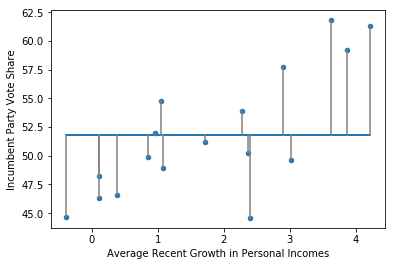

In [16]:
feature = 'Average Recent Growth in Personal Incomes'
regression_residuals(df, feature, target, m=0, b=y.mean())

Mean Absolute Error: 2.556470588235295
R^2: 0.5799637280695265


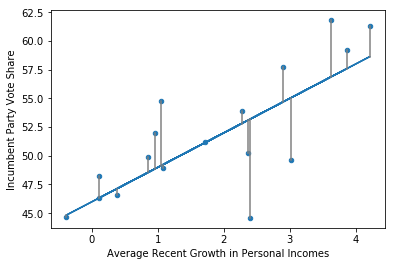

In [17]:
regression_residuals(df, feature, target, m=3, b=46)

In [18]:
from ipywidgets import interact, fixed

interact(
    regression_residuals, 
    df=fixed(df), 
    feature=fixed(feature), 
    target=fixed(target), 
    m=(-5,5,0.5), 
    b=(40,60,0.5)
);

interactive(children=(FloatSlider(value=0.0, description='m', max=5.0, min=-5.0, step=0.5), FloatSlider(value=…

Mean Squared Error: 12.00542352941177
Root Mean Squared Error: 3.4648843457483207
Mean Absolute Error: 2.556470588235295
R^2: 0.5799637280695265


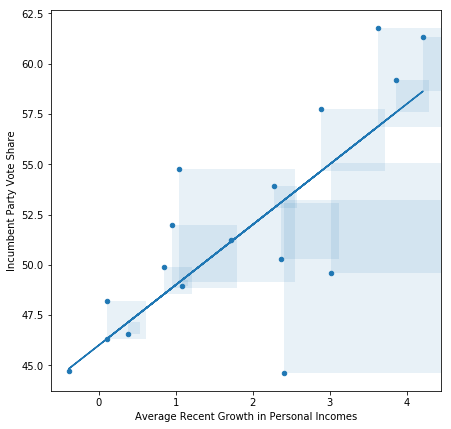

In [19]:
# But Ordinary Least Squares Regression *doesn't* directly minimize MAE or R^2...
regression_squared_errors(df, feature, target, m=3, b=46)

## Linear Algebra

The same result that is found by minimizing the sum of the squared errors can be also found through a linear algebra process known as the "Least Squares Solution:"

\begin{align}
\hat{\beta} = (X^{T}X)^{-1}X^{T}y
\end{align}

Before we can work with this equation in its linear algebra form we have to understand how to set up the matrices that are involved in this equation. 

### The $\beta$ vector

The $\beta$ vector represents all the parameters that we are trying to estimate, our $y$ vector and $X$ matrix values are full of data from our dataset. The $\beta$ vector holds the variables that we are solving for: $\beta_0$ and $\beta_1$

Now that we have all of the necessary parts we can set them up in the following equation:

\begin{align}
y = X \beta + \epsilon
\end{align}

Since our $\epsilon$ value represents **random** error we can assume that it will equal zero on average.

\begin{align}
y = X \beta
\end{align}

The objective now is to isolate the $\beta$ matrix. We can do this by pre-multiplying both sides by "X transpose" $X^{T}$.

\begin{align}
X^{T}y =  X^{T}X \beta
\end{align}

Since anything times its transpose will result in a square matrix, if that matrix is then an invertible matrix, then we should be able to multiply both sides by its inverse to remove it from the right hand side. (We'll talk tomorrow about situations that could lead to $X^{T}X$ not being invertible.)

\begin{align}
(X^{T}X)^{-1}X^{T}y =  (X^{T}X)^{-1}X^{T}X \beta
\end{align}

Since any matrix multiplied by its inverse results in the identity matrix, and anything multiplied by the identity matrix is itself, we are left with only $\beta$ on the right hand side:

\begin{align}
(X^{T}X)^{-1}X^{T}y = \hat{\beta}
\end{align}

We will now call it "beta hat" $\hat{\beta}$ because it now represents our estimated values for $\beta_0$ and $\beta_1$

### Lets calculate our $\beta$ coefficients with numpy!

In [20]:
# This is NOT an objective you'll be tested on. It's just a demo.

# X is a matrix. Add constant for the intercept.
from statsmodels.api import add_constant
X = add_constant(df[feature].values)
print('X')
print(X)

# y is a column vector
y = df[target].values[:, np.newaxis]
print('y')
print(y)

# Least squares solution in code
X_transpose = X.T
X_transpose_X = X_transpose @ X
X_transpose_X_inverse = np.linalg.inv(X_transpose_X)
X_transpose_y = X_transpose @ y
beta_hat = X_transpose_X_inverse @ X_transpose_y

print('Beta Hat')
print(beta_hat)

X
[[ 1.    2.4 ]
 [ 1.    2.89]
 [ 1.    0.85]
 [ 1.    4.21]
 [ 1.    3.02]
 [ 1.    3.62]
 [ 1.    1.08]
 [ 1.   -0.39]
 [ 1.    3.86]
 [ 1.    2.27]
 [ 1.    0.38]
 [ 1.    1.04]
 [ 1.    2.36]
 [ 1.    1.72]
 [ 1.    0.1 ]
 [ 1.    0.95]
 [ 1.    0.1 ]]
y
[[44.6 ]
 [57.76]
 [49.91]
 [61.34]
 [49.6 ]
 [61.79]
 [48.95]
 [44.7 ]
 [59.17]
 [53.94]
 [46.55]
 [54.74]
 [50.27]
 [51.24]
 [46.32]
 [52.  ]
 [48.2 ]]
Beta Hat
[[46.49920976]
 [ 2.97417709]]


In [21]:
# Scikit-learn gives the exact same results
from sklearn.linear_model import LinearRegression
model = LinearRegression()
features # What's the equation for the hyperplane?
# Can you relate the intercept and coefficients to what you see in the plot?
from sklearn.linear_model import LinearRegression
model = LinearRegression()
features = ['Average Recent Growth in Personal Incomes', 
            'US Military Fatalities per Million']
target = 'Incumbent Party Vote Share'
X = df[features]
y = df[target]
model.fit(X, y)
model.intercept_, model.coef_= ['Average Recent Growth in Personal Incomes']
target = 'Incumbent Party Vote Share'
X = df[features]
y = df[target]
model.fit(X, y)
model.intercept_, model.coef_

(46.499209757741625, array([2.97417709]))

In [23]:
# Fit a multiple regression model and plot the hyperplane of best fit
regression_3d(
    df, 
    x='Average Recent Growth in Personal Incomes', 
    y='US Military Fatalities per Million', 
    z='Incumbent Party Vote Share', 
    text='Year', 
    title='US Presidential Elections, 1952-2016'
)

In [27]:
# What's the equation for the hyperplane?
# Can you relate the intercept and coefficients to what you see in the plot?
from sklearn.linear_model import LinearRegression
model = LinearRegression()
features = ['Average Recent Growth in Personal Incomes', 
            'US Military Fatalities per Million']
target = 'Incumbent Party Vote Share'
X = df[features]
y = df[target]
model.fit(X, y)
model.intercept_, model.coef_

(46.88551694148949, array([ 3.40621407, -0.05375223]))

In [28]:
# This is easier to read
print('Intercept', model.intercept_)
coefficients = pd.Series(model.coef_, features)
print(coefficients.to_string())

Intercept 46.88551694148949
Average Recent Growth in Personal Incomes    3.406214
US Military Fatalities per Million          -0.053752


In [29]:
# What if ...

# Income growth = 0%, fatalities = 0
model.predict([[0, 0]])

array([46.88551694])

In [30]:
# Income growth = 1% (fatalities = 0)
model.predict([[1, 0]])

array([50.29173101])

In [31]:
# The difference between these predictions = income coefficient
model.predict([[1, 0]]) - model.predict([[0, 0]])

array([3.40621407])

In [32]:
# What if... income growth = 2% (fatalities = 0)
model.predict([[2, 0]])

array([53.69794508])

In [33]:
# The difference between these predictions = income coefficient
model.predict([[2, 0]]) - model.predict([[1, 0]])

array([3.40621407])

In [34]:
# What if... (income growth=2%) fatalities = 100
model.predict([[2, 100]])

array([48.32272205])

In [35]:
# The difference between these predictions = 100 * fatalities coefficient
model.predict([[2, 100]]) - model.predict([[2, 0]])

array([-5.37522303])

In [36]:
# What if income growth = 3% (fatalities = 100)
model.predict([[3, 100]])

array([51.72893612])

In [37]:
# The difference between these predictions = income coefficient
model.predict([[3, 100]]) - model.predict([[2, 100]])

array([3.40621407])

In [38]:
# What if (income growth = 3%) fatalities = 200
model.predict([[3, 200]])

array([46.35371309])

In [39]:
# The difference between these predictions = 100 * fatalities coefficient
model.predict([[3, 200]]) - model.predict([[3, 100]])

array([-5.37522303])

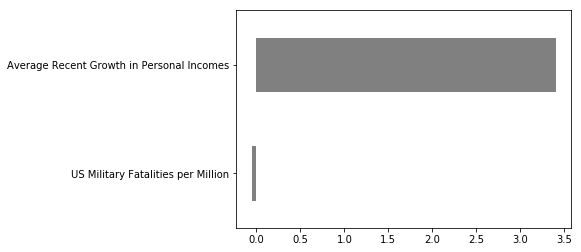

In [40]:
# Plot coefficients
%matplotlib inline
coefficients.sort_values().plot.barh(color='grey');

In [41]:
# Note that the features are on different scales,
# so the coefficients are on different scales too
df[features].describe()

,Average Recent Growth in Personal Incomes,US Military Fatalities per Million
count,17.000000,17.000000
mean,1.791765,21.588235
std,1.419812,55.767440
min,-0.390000,0.000000
25%,0.850000,0.000000
50%,1.720000,0.000000
75%,2.890000,5.000000
max,4.210000,190.000000


## Overfitting Demo

In [0]:
# Read New York City property sales data, from first 4 months of 2019.
# Dataset has 23040 rows, 21 columns.
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')
assert df.shape == (23040, 21)

# Change column names. Replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# Remove symbols from SALE_PRICE string, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

# Keep subset of rows:
# Tribeca neighborhood, Condos - Elevator Apartments, 
# 1 unit, sale price more than $1, less than $35 million
mask = (
    (df['NEIGHBORHOOD'].str.contains('TRIBECA')) & 
    (df['BUILDING_CLASS_CATEGORY'] == '13 CONDOS - ELEVATOR APARTMENTS') &
    (df['TOTAL_UNITS'] == 1) & 
    (df['SALE_PRICE'] > 0) & 
    (df['SALE_PRICE'] < 35000000)
)
df = df[mask]

# Data now has 90 rows, 21 columns
assert df.shape == (90, 21)

# Convert SALE_DATE to datetime
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)

from ipywidgets import interact
import pandas as pd
from sklearn.linear_model import LinearRegression

# Read New York City property sales data, from first 4 months of 2019.
# Dataset has 23040 rows, 21 columns.
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')
assert df.shape == (23040, 21)

# Change column names. Replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# Remove symbols from SALE_PRICE string, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

# Keep subset of rows:
# Tribeca neighborhood, Condos - Elevator Apartments, 
# 1 unit, sale price more than $1, less than $35 million
mask = (
    (df['NEIGHBORHOOD'].str.contains('TRIBECA')) & 
    (df['BUILDING_CLASS_CATEGORY'] == '13 CONDOS - ELEVATOR APARTMENTS') &
    (df['TOTAL_UNITS'] == 1) & 
    (df['SALE_PRICE'] > 0) & 
    (df['SALE_PRICE'] < 35000000)
)
df = df[mask]

# Data now has 90 rows, 21 columns
assert df.shape == (90, 21)

# Convert SALE_DATE to datetime
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)

# Arrange X features matrix & y target vector
features = ['GROSS_SQUARE_FEET']
target = 'SALE_PRICE'
X = df[features]
y = df[target]

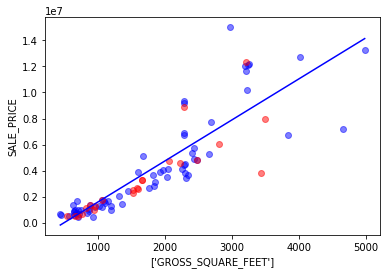

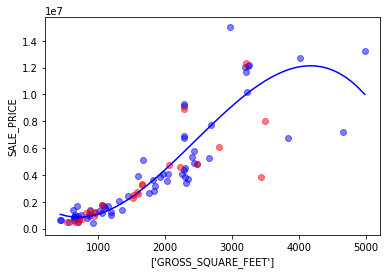

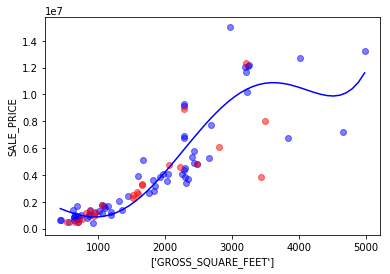

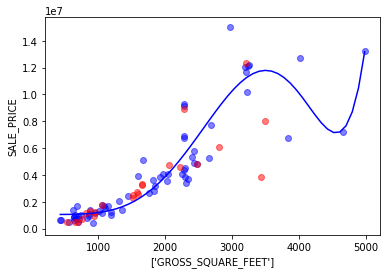

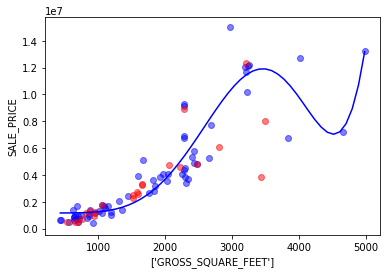

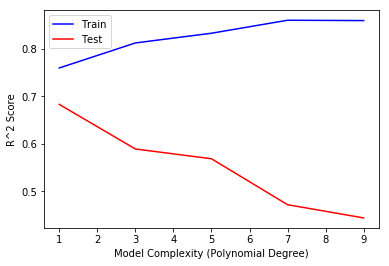

In [43]:
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)

# Repeatedly fit increasingly complex models, and keep track of the scores
polynomial_degrees = range(1, 10, 2)
train_r2s = []
test_r2s = []

for degree in polynomial_degrees:
    model = PolynomialRegression(degree)
    display(HTML(f'Polynomial degree={degree}'))
    
    model.fit(X_train, y_train)
    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)
    display(HTML(f'<b style="color: blue">Train R2 {train_r2:.2f}</b>'))
    display(HTML(f'<b style="color: red">Test R2 {test_r2:.2f}</b>'))

    plt.scatter(X_train, y_train, color='blue', alpha=0.5)
    plt.scatter(X_test, y_test, color='red', alpha=0.5)
    plt.xlabel(features)
    plt.ylabel(target)
    
    x_domain = np.linspace(X.min(), X.max())
    curve = model.predict(x_domain)
    plt.plot(x_domain, curve, color='blue')
    plt.show()
    display(HTML('<hr/>'))
    
    train_r2s.append(train_r2)
    test_r2s.append(test_r2)
    
display(HTML('Validation Curve'))
plt.plot(polynomial_degrees, train_r2s, color='blue', label='Train')
plt.plot(polynomial_degrees, test_r2s, color='red', label='Test')
plt.xlabel('Model Complexity (Polynomial Degree)')
plt.ylabel('R^2 Score')
plt.legend()
plt.show()

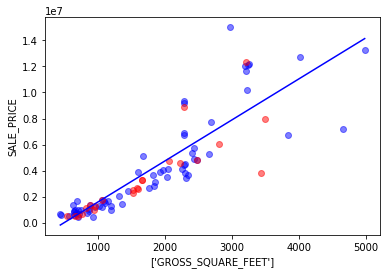

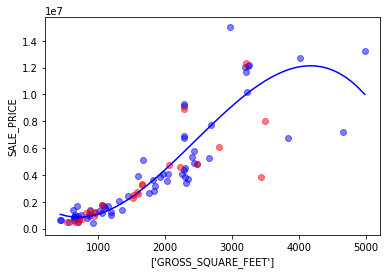

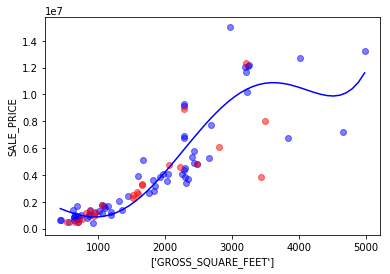

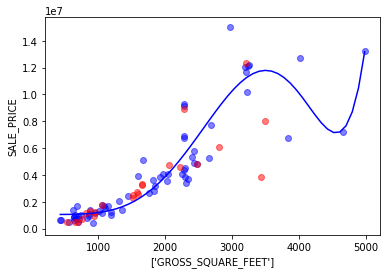

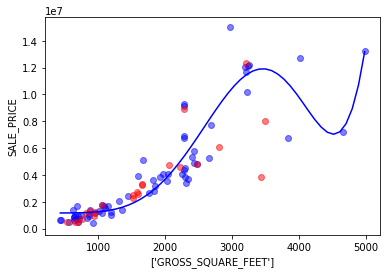

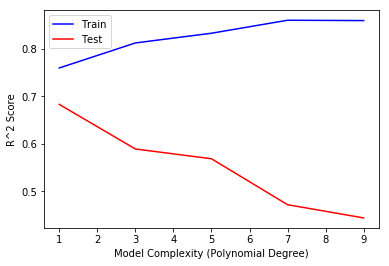

In [44]:
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)

# Repeatedly fit increasingly complex models, and keep track of the scores
polynomial_degrees = range(1, 10, 2)
train_r2s = []
test_r2s = []

for degree in polynomial_degrees:
    model = PolynomialRegression(degree)
    display(HTML(f'Polynomial degree={degree}'))
    
    model.fit(X_train, y_train)
    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)
    display(HTML(f'<b style="color: blue">Train R2 {train_r2:.2f}</b>'))
    display(HTML(f'<b style="color: red">Test R2 {test_r2:.2f}</b>'))

    plt.scatter(X_train, y_train, color='blue', alpha=0.5)
    plt.scatter(X_test, y_test, color='red', alpha=0.5)
    plt.xlabel(features)
    plt.ylabel(target)
    
    x_domain = np.linspace(X.min(), X.max())
    curve = model.predict(x_domain)
    plt.plot(x_domain, curve, color='blue')
    plt.show()
    display(HTML('<hr/>'))
    
    train_r2s.append(train_r2)
    test_r2s.append(test_r2)
    
display(HTML('Validation Curve'))
plt.plot(polynomial_degrees, train_r2s, color='blue', label='Train')
plt.plot(polynomial_degrees, test_r2s, color='red', label='Test')
plt.xlabel('Model Complexity (Polynomial Degree)')
plt.ylabel('R^2 Score')
plt.legend()
plt.show()

#### Jake VanderPlas, [_Python Data Science Handbook,_ Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#The-Bias-variance-trade-off)

![](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-validation-curve.png)